# 라이브러리 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

import lightgbm as lgb

from geopy.distance import geodesic

# 랜덤 시드 설정

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
import seaborn as sns
print(sns.__version__)

0.13.2


# 데이터 불러오기

In [4]:
data_path = "/data/ephemeral/home/level2-competitiveds-recsys-01/data"
train_data = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_data = pd.read_csv(os.path.join(data_path, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))

In [5]:
interest_rate = pd.read_csv(os.path.join(data_path, "interestRate.csv"))
park_info = pd.read_csv(os.path.join(data_path, "parkInfo.csv"))
school_info = pd.read_csv(os.path.join(data_path, "schoolinfo.csv"))
subway_info = pd.read_csv(os.path.join(data_path, "subwayInfo.csv"))

In [6]:
train_data['year'] = train_data['contract_year_month'].astype(str).str[:4].astype(int)
train_data['month'] = train_data['contract_year_month'].astype(str).str[4:].astype(int)
train_data['date'] = pd.to_datetime(train_data['year'].astype(str) + train_data['month'].astype(str).str.zfill(2) + train_data['contract_day'].astype(str).str.zfill(2))


In [116]:
interest_rate

,year_month,interest_rate
0,202405,3.56
1,202404,3.54
2,202403,3.59
3,202402,3.62
4,202401,3.66
...,...,...
61,201904,1.85
62,201903,1.94
63,201902,1.92
64,201901,1.99


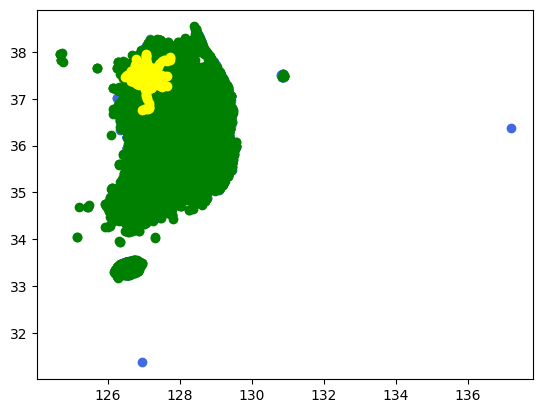

In [22]:
plt.scatter(train_data['longitude'], train_data['latitude'], color = 'tomato')
plt.scatter(park_info['longitude'], park_info['latitude'], color = 'royalblue')
plt.scatter(school_info['longitude'], school_info['latitude'], color = 'green')
plt.scatter(subway_info['longitude'], subway_info['latitude'], color = 'yellow')

# 범위를 수도권으로 축소

In [23]:
min_latitude = min(train_data['latitude'])
max_latitude = max(train_data['latitude'])

min_longitude = min(train_data['longitude'])
max_longitude = max(train_data['longitude'])

school_info_filtered = school_info[(school_info['latitude'] >= min_latitude) & (school_info['latitude'] <= max_latitude) & (school_info['longitude'] >= min_longitude) & (school_info['longitude'] <= max_longitude)]
park_info_filtered = park_info[(park_info['latitude'] >= min_latitude) & (park_info['latitude'] <= max_latitude) & (park_info['longitude'] >= min_longitude) & (park_info['longitude'] <= max_longitude)]
subway_info_filtered = subway_info[(subway_info['latitude'] >= min_latitude) & (subway_info['latitude'] <= max_latitude) & (subway_info['longitude'] >= min_longitude) & (subway_info['longitude'] <= max_longitude)]

In [37]:
print(train_data.shape)
print(school_info_filtered.shape)
print(park_info_filtered.shape)
print(park_info_filtered.shape)

(1801228, 15)
(4375, 4)
(7370, 3)
(7370, 3)


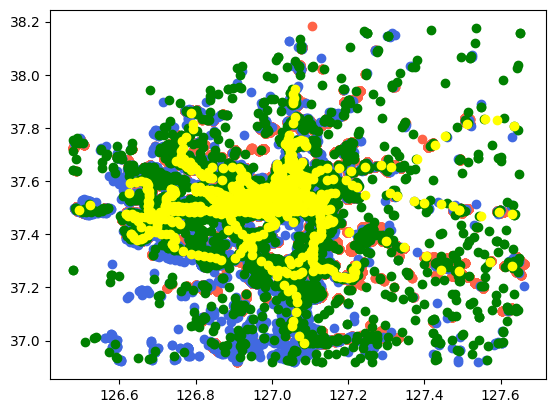

In [25]:
plt.scatter(train_data['longitude'], train_data['latitude'], color = 'tomato')
plt.scatter(park_info_filtered['longitude'], park_info_filtered['latitude'], color = 'royalblue')
plt.scatter(school_info_filtered['longitude'], school_info_filtered['latitude'], color = 'green')
plt.scatter(subway_info_filtered['longitude'], subway_info_filtered['latitude'], color = 'yellow')

# train_data 기준으로 클러스터 나눠서 school, ppark, subway를 각 클러스터에 할당

In [66]:
# train_data로 클러스터 형성
X_train = train_data[['latitude', 'longitude']].values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

kmeans = KMeans(n_clusters=25, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X_train_scaled)

# 다른 데이터셋에 클러스터 할당
def assign_cluster(data):
    X = data[['latitude', 'longitude']].values
    X_scaled = scaler.transform(X)
    return kmeans.predict(X_scaled)

train_data['cluster'] = kmeans.labels_
school_info_filtered['cluster'] = assign_cluster(school_info_filtered)
subway_info_filtered['cluster'] = assign_cluster(subway_info_filtered)
park_info_filtered['cluster'] = assign_cluster(park_info_filtered)

/tmp/ipykernel_404518/2363754291.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_info_filtered['cluster'] = assign_cluster(school_info_filtered)
/tmp/ipykernel_404518/2363754291.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subway_info_filtered['cluster'] = assign_cluster(subway_info_filtered)
/tmp/ipykernel_404518/2363754291.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [67]:
subway_info_filtered

,latitude,longitude,cluster
0,37.759380,127.042292,6
1,37.541021,126.971300,1
2,37.529849,126.964561,1
3,37.514219,126.942454,1
4,37.513342,126.926382,1
...,...,...,...
695,37.378384,126.645168,3
696,37.386007,126.639484,3
697,37.393054,126.634729,3
698,37.399907,126.630347,3


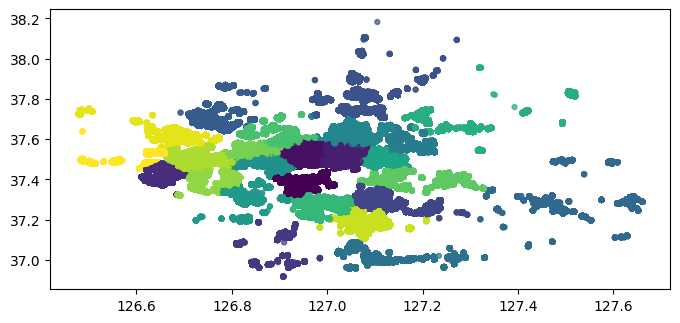

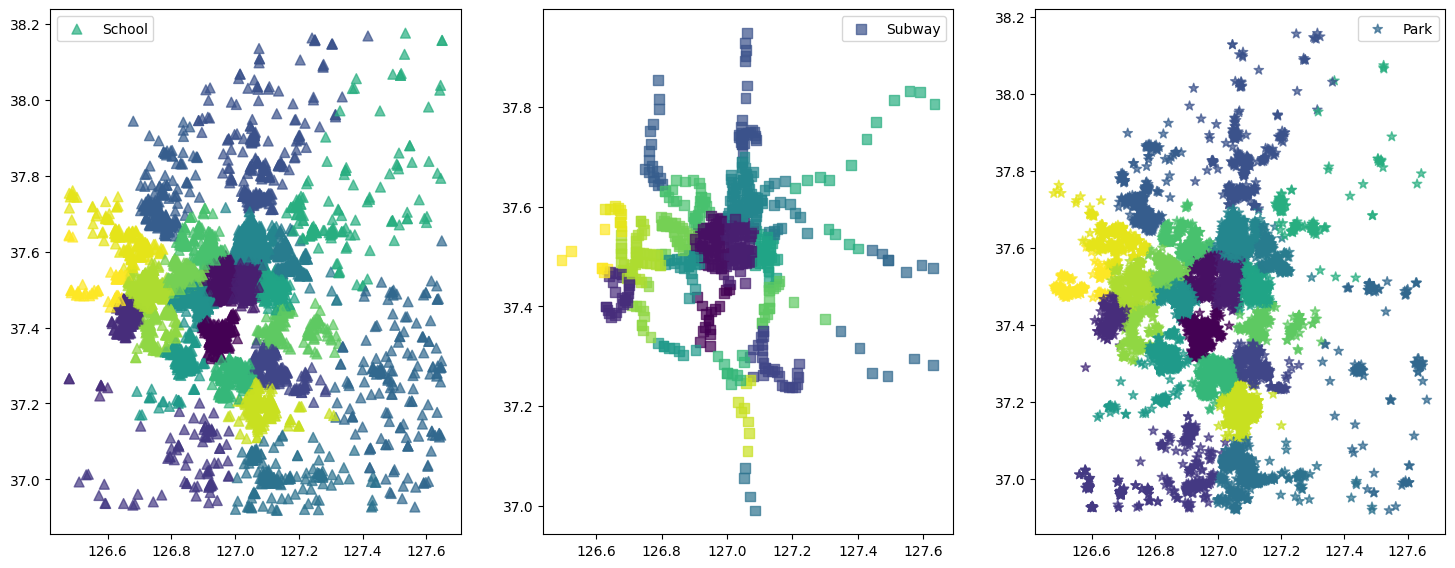

In [113]:
fig = plt.figure(figsize=(8, 8))

ax_s0 = fig.add_subplot(2, 1, 1)
ax_s0.scatter(train_data['longitude'], train_data['latitude'], marker='.', s=50, alpha=0.7, label='apartment', c = train_data['cluster'])

fig = plt.figure(figsize=(18, 15))
ax_s1 = fig.add_subplot(2, 3, 4)
ax_s2 = fig.add_subplot(2, 3, 5)
ax_s3 = fig.add_subplot(2, 3, 6)

ax_s1.scatter(school_info_filtered['longitude'], school_info_filtered['latitude'], marker='^', s=50, alpha=0.7, label='School', c = school_info_filtered['cluster'])
ax_s2.scatter(subway_info_filtered['longitude'], subway_info_filtered['latitude'], marker='s', s=50, alpha=0.7, label='Subway', c = subway_info_filtered['cluster'])
ax_s3.scatter(park_info_filtered['longitude'], park_info_filtered['latitude'], marker='*', s=50, alpha=0.7, label='Park', c = park_info_filtered['cluster'])
ax_s1.legend()
ax_s2.legend()
ax_s3.legend()

클러스터 1: 98692개 학교
클러스터 2: 89020개 학교
클러스터 3: 98174개 학교
클러스터 4: 94337개 학교
클러스터 5: 61453개 학교
클러스터 6: 105588개 학교
클러스터 7: 13596개 학교
클러스터 8: 116241개 학교
클러스터 9: 75932개 학교
클러스터 10: 96242개 학교
클러스터 11: 84275개 학교
클러스터 12: 51467개 학교
클러스터 13: 43920개 학교
클러스터 14: 19864개 학교
클러스터 15: 104715개 학교
클러스터 16: 91129개 학교
클러스터 17: 71778개 학교
클러스터 18: 16501개 학교
클러스터 19: 35891개 학교
클러스터 20: 52160개 학교
클러스터 21: 47868개 학교
클러스터 22: 66979개 학교
클러스터 23: 88716개 학교
클러스터 24: 41982개 학교
클러스터 25: 134708개 학교


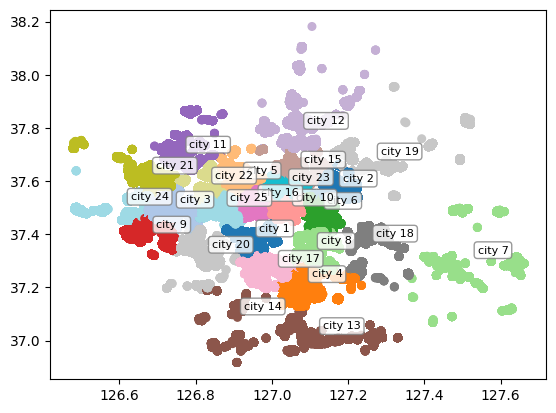

In [65]:
from sklearn.cluster import KMeans


X = train_data[['latitude', 'longitude']].values

# K-means 클러스터링 수행 (25개 클러스터)
kmeans = KMeans(n_clusters=25, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X)

# 클러스터 레이블 추가
train_data['cluster'] = kmeans.labels_

# 결과 시각화
plt.scatter(train_data['longitude'], train_data['latitude'], 
                      c=train_data['cluster'], cmap='tab20', s=30)

# 클러스터 중심에 라벨 추가
cluster_centers = kmeans.cluster_centers_
for i, center in enumerate(cluster_centers):
    plt.annotate(f'city {i+1}', (center[1], center[0]), xytext=(5, 5), 
                 textcoords='offset points', fontsize=8, 
                 bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))
    

# 각 클러스터에 속한 학교 수 출력
cluster_counts = train_data['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"클러스터 {cluster+1}: {count}개 학교")

/tmp/ipykernel_404518/3578493050.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_info_filtered['cluster'] = kmeans.labels_


클러스터 1: 223개 학교
클러스터 2: 404개 학교
클러스터 3: 212개 학교
클러스터 4: 56개 학교
클러스터 5: 305개 학교
클러스터 6: 36개 학교
클러스터 7: 185개 학교
클러스터 8: 140개 학교
클러스터 9: 213개 학교
클러스터 10: 140개 학교
클러스터 11: 337개 학교
클러스터 12: 70개 학교
클러스터 13: 218개 학교
클러스터 14: 195개 학교
클러스터 15: 292개 학교
클러스터 16: 200개 학교
클러스터 17: 68개 학교
클러스터 18: 84개 학교
클러스터 19: 63개 학교
클러스터 20: 36개 학교
클러스터 21: 86개 학교
클러스터 22: 41개 학교
클러스터 23: 347개 학교
클러스터 24: 90개 학교
클러스터 25: 334개 학교


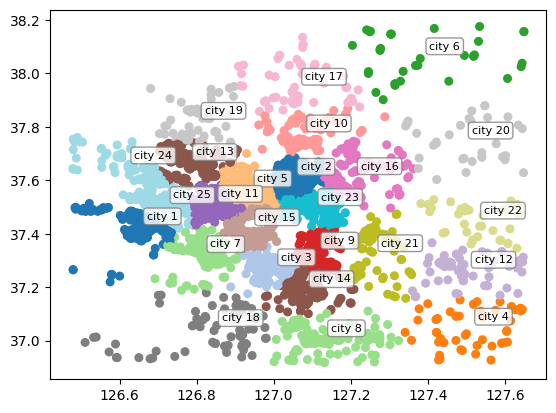

In [54]:
from sklearn.cluster import KMeans


X = school_info_filtered[['latitude', 'longitude']].values

# K-means 클러스터링 수행 (25개 클러스터)
kmeans = KMeans(n_clusters=25, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X)

# 클러스터 레이블 추가
school_info_filtered['cluster'] = kmeans.labels_

# 결과 시각화
plt.scatter(school_info_filtered['longitude'], school_info_filtered['latitude'], 
                      c=school_info_filtered['cluster'], cmap='tab20', s=30)

# 클러스터 중심에 라벨 추가
cluster_centers = kmeans.cluster_centers_
for i, center in enumerate(cluster_centers):
    plt.annotate(f'city {i+1}', (center[1], center[0]), xytext=(5, 5), 
                 textcoords='offset points', fontsize=8, 
                 bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))
    

# 각 클러스터에 속한 학교 수 출력
cluster_counts = school_info_filtered['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"클러스터 {cluster+1}: {count}개 학교")

/tmp/ipykernel_404518/2124073110.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  park_info_filtered['cluster'] = kmeans.labels_


클러스터 1: 364개 공원
클러스터 2: 455개 공원
클러스터 3: 291개 공원
클러스터 4: 503개 공원
클러스터 5: 112개 공원
클러스터 6: 424개 공원
클러스터 7: 394개 공원
클러스터 8: 49개 공원
클러스터 9: 533개 공원
클러스터 10: 308개 공원
클러스터 11: 411개 공원
클러스터 12: 63개 공원
클러스터 13: 44개 공원
클러스터 14: 92개 공원
클러스터 15: 268개 공원
클러스터 16: 358개 공원
클러스터 17: 349개 공원
클러스터 18: 205개 공원
클러스터 19: 418개 공원
클러스터 20: 509개 공원
클러스터 21: 27개 공원
클러스터 22: 344개 공원
클러스터 23: 122개 공원
클러스터 24: 451개 공원
클러스터 25: 276개 공원


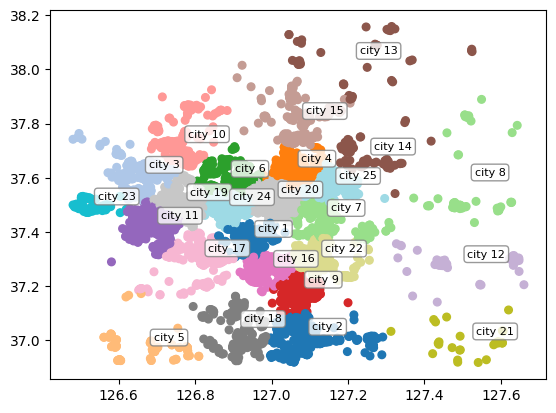

In [63]:
from sklearn.cluster import KMeans


X = park_info_filtered[['latitude', 'longitude']].values

# K-means 클러스터링 수행 (25개 클러스터)
kmeans = KMeans(n_clusters=25, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X)

# 클러스터 레이블 추가
park_info_filtered['cluster'] = kmeans.labels_

# 결과 시각화
plt.scatter(park_info_filtered['longitude'], park_info_filtered['latitude'], 
                      c=park_info_filtered['cluster'], cmap='tab20', s=30)

# 클러스터 중심에 라벨 추가
cluster_centers = kmeans.cluster_centers_
for i, center in enumerate(cluster_centers):
    plt.annotate(f'city {i+1}', (center[1], center[0]), xytext=(5, 5), 
                 textcoords='offset points', fontsize=8, 
                 bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))
    

# 각 클러스터에 속한 공원 수 출력
cluster_counts = park_info_filtered['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"클러스터 {cluster+1}: {count}개 공원")

/tmp/ipykernel_404518/3410946022.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subway_info_filtered['cluster'] = kmeans.labels_


클러스터 1: 62개 지하철
클러스터 2: 18개 지하철
클러스터 3: 6개 지하철
클러스터 4: 22개 지하철
클러스터 5: 24개 지하철
클러스터 6: 50개 지하철
클러스터 7: 68개 지하철
클러스터 8: 13개 지하철
클러스터 9: 7개 지하철
클러스터 10: 38개 지하철
클러스터 11: 6개 지하철
클러스터 12: 21개 지하철
클러스터 13: 57개 지하철
클러스터 14: 56개 지하철
클러스터 15: 18개 지하철
클러스터 16: 6개 지하철
클러스터 17: 28개 지하철
클러스터 18: 18개 지하철
클러스터 19: 7개 지하철
클러스터 20: 24개 지하철
클러스터 21: 39개 지하철
클러스터 22: 44개 지하철
클러스터 23: 7개 지하철
클러스터 24: 11개 지하철
클러스터 25: 36개 지하철


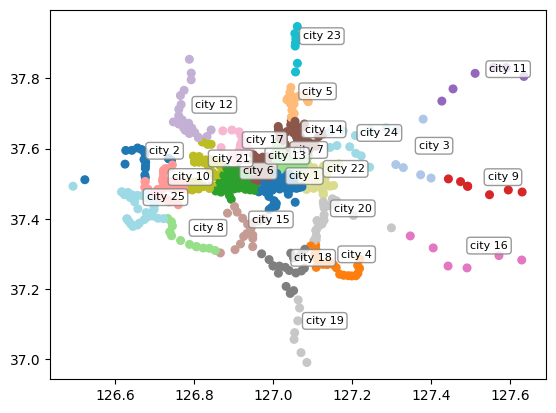

In [64]:
from sklearn.cluster import KMeans


X = subway_info_filtered[['latitude', 'longitude']].values

# K-means 클러스터링 수행 (25개 클러스터)
kmeans = KMeans(n_clusters=25, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X)

# 클러스터 레이블 추가
subway_info_filtered['cluster'] = kmeans.labels_

# 결과 시각화
plt.scatter(subway_info_filtered['longitude'], subway_info_filtered['latitude'], 
                      c=subway_info_filtered['cluster'], cmap='tab20', s=30)

# 클러스터 중심에 라벨 추가
cluster_centers = kmeans.cluster_centers_
for i, center in enumerate(cluster_centers):
    plt.annotate(f'city {i+1}', (center[1], center[0]), xytext=(5, 5), 
                 textcoords='offset points', fontsize=8, 
                 bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))
    

# 각 클러스터에 속한 지하철 수 출력
cluster_counts = subway_info_filtered['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"클러스터 {cluster+1}: {count}개 지하철")

# park, school, subway 수도권 범위로 축소

In [216]:
min_latitude = min(train_data['latitude'])
max_latitude = max(train_data['latitude'])

min_longitude = min(train_data['longitude'])
max_longitude = max(train_data['longitude'])

In [217]:
school_info_filtered = school_info[(school_info['latitude'] >= min_latitude) & (school_info['latitude'] <= max_latitude) & (school_info['longitude'] >= min_longitude) & (school_info['longitude'] <= max_longitude)]
park_info_filtered = park_info[(park_info['latitude'] >= min_latitude) & (park_info['latitude'] <= max_latitude) & (park_info['longitude'] >= min_longitude) & (park_info['longitude'] <= max_longitude)]
subway_info_filtered = subway_info[(subway_info['latitude'] >= min_latitude) & (subway_info['latitude'] <= max_latitude) & (subway_info['longitude'] >= min_longitude) & (subway_info['longitude'] <= max_longitude)]

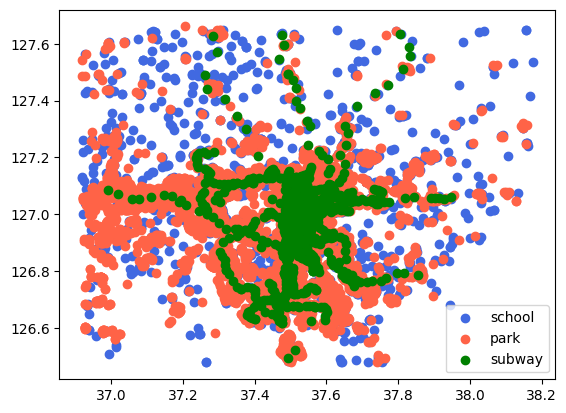

In [218]:
plt.scatter(school_info_filtered['latitude'], school_info_filtered['longitude'], color = 'royalblue', label = 'school')
plt.scatter(park_info_filtered['latitude'], park_info_filtered['longitude'], color = 'tomato', label = 'park')
plt.scatter(subway_info_filtered['latitude'], subway_info_filtered['longitude'], color = 'green', label = 'subway')
plt.legend()
plt.show()

In [219]:
print(school_info_filtered.shape[0])
print(park_info_filtered.shape[0])
print(subway_info_filtered.shape[0])

4375
7370
686


<AxesSubplot:xlabel='area_m2', ylabel='deposit'>

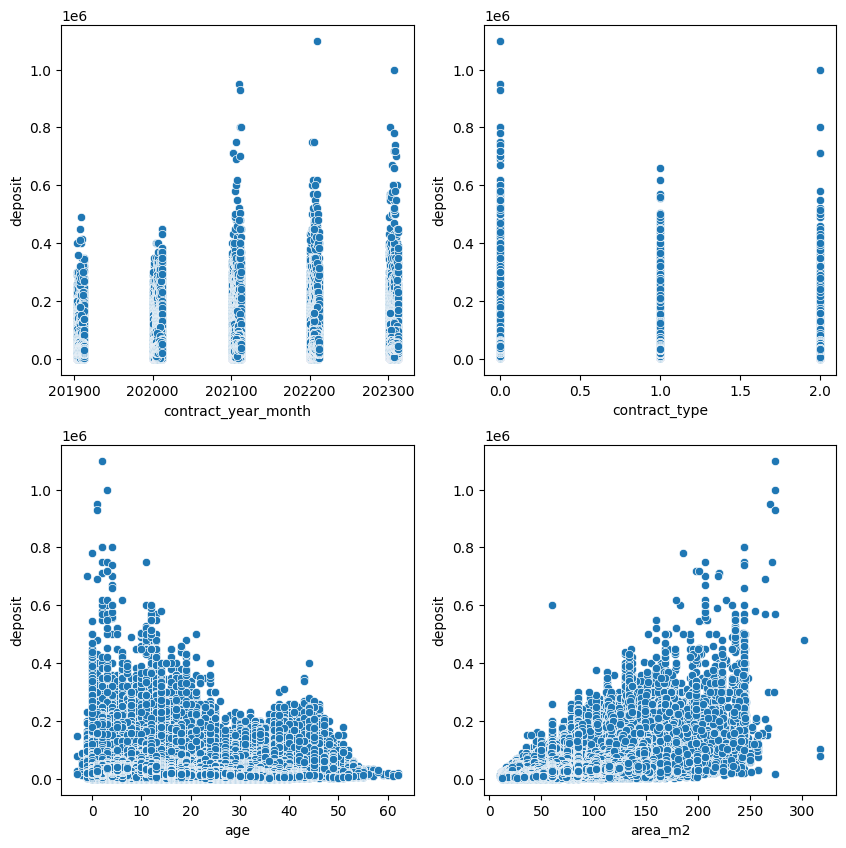

In [220]:
fig, axes = plt.subplots(2, 2, figsize = (10,10))
sns.scatterplot(data=train_data, x='contract_year_month', y='deposit', ax = axes[0][0])
sns.scatterplot(data=train_data, x='contract_type', y='deposit', ax = axes[0][1])
sns.scatterplot(data=train_data, x='age', y='deposit', ax = axes[1][0])
sns.scatterplot(data=train_data, x='area_m2', y='deposit', ax = axes[1][1])


In [221]:
train_data = train_data.set_index('date')

In [222]:
tmp_2019 = train_data[train_data['year'] == 2019]
tmp_2020 = train_data[train_data['year'] == 2020]
tmp_2021 = train_data[train_data['year'] == 2021]
tmp_2022 = train_data[train_data['year'] == 2022]
tmp_2023 = train_data[train_data['year'] == 2023]

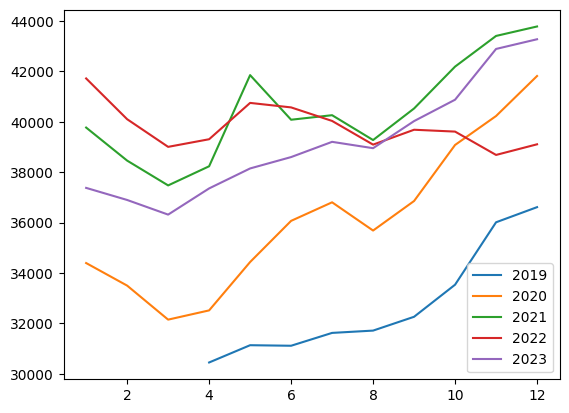

In [223]:
plt.plot(tmp_2019.groupby('month').mean()['deposit'], label = '2019')
plt.plot(tmp_2020.groupby('month').mean()['deposit'], label = '2020')
plt.plot(tmp_2021.groupby('month').mean()['deposit'], label = '2021')
plt.plot(tmp_2022.groupby('month').mean()['deposit'], label = '2022')
plt.plot(tmp_2023.groupby('month').mean()['deposit'], label = '2023')
plt.legend()

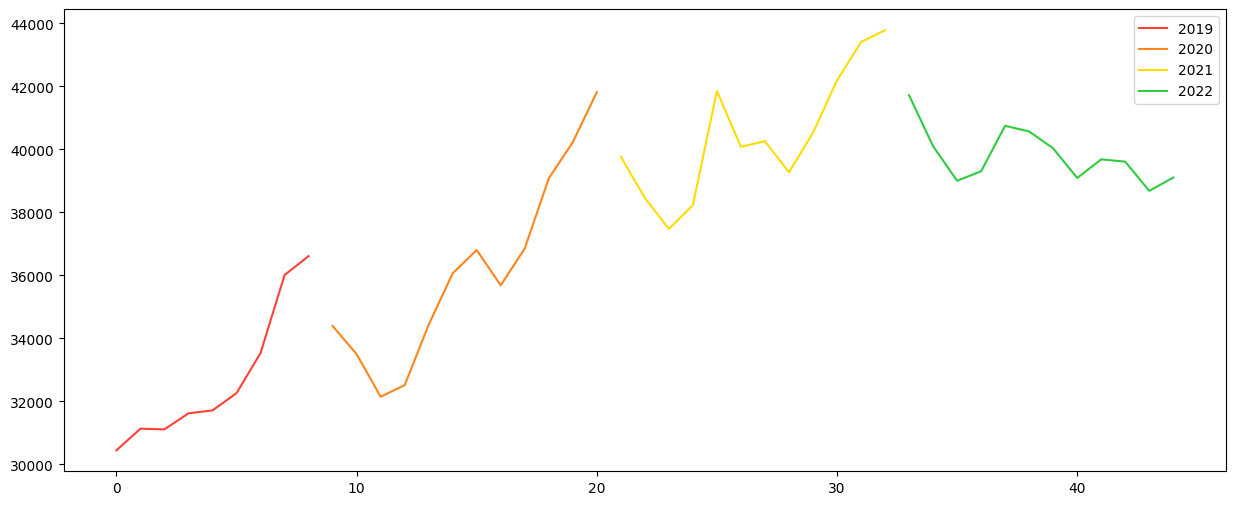

In [224]:
combined_list = train_data.sort_index().groupby('contract_year_month').mean()['deposit'].tolist()
# x축 값 생성
x = np.arange(len(combined_list))
years = [2019,2020,2021,2022]
colors = ['#FF4136', '#FF851B', '#FFDC00', '#2ECC40', '#0074D9']
# 플롯 생성
plt.figure(figsize=(15, 6))

for i in range(len(years)):
    if i == 0:
        plt.plot(x[:9], combined_list[:9], color=colors[i], label=years[i])
    else:
        plt.plot(x[9+(12*(i-1)) : 9+(12*(i))], combined_list[9+(12*(i-1)) : 9+(12*(i))], color=colors[i], label=years[i])

plt.legend()
plt.show()